# Policy gradient method

We try out a basic version of the policy gradient method on the cart pole RL task, see [here](https://gymnasium.farama.org/environments/classic_control/cart_pole/).

The pole balancing task is implemented in the package <code>gymnasium</code> that you need to install. The package provides a framework for reinforcement tasks and a number of fun tasks. Check it out here: https://gymnasium.farama.org/

In [1]:
## install gymnasium in colab via
# !pip install gymnasium

import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

## Policy gradient method

The implementation of the method is quite straightforward: 
* generate a small number of episodes (<code>batch_size</code> many) following the current policy $\pi_w$
* for each episode (with trajectory $\tau$) compute $$\Delta=(G(\tau)-b)\sum_{t=0}^T\frac{\nabla \pi_w(a_t|s_t)}{\pi_w(a_t|s_t)},$$ where $G(\tau)$ is the total reward (here: episode length) and $b$ is suitable baseline (here: a Monte Carlo estimation of mean episode length)
* take the mean over all $\Delta$ in the current batch and perform the following weight update $$w^{(t+1)}=w^{(t)}+\eta_t\Delta,$$ where $\eta_t$ is the current learning rate

Note: this is not the best implementation of the method -- but it is simple and works for the cart pole task. For a better and more sophisticated implementation see [here](https://spinningup.openai.com/en/latest/spinningup/rl_intro3.html).

In [2]:
# decaying learning rate
def power_rate_factory(eta0,decay):
    def learning_rate(i):
        return eta0/(1+i*decay)
    return learning_rate

from gymnasium.wrappers import TimeLimit

class PGM:
    def __init__(self,env,learning_rate,policy,policy_gradient,starting_weight,iterations,record_weight=None,batch_size=10,time_limit=500):
        """
        env: the RL environment
        learning_rate: a function that, given the timestep i, returns the current learning rate
        iterations: run for this many iterations
        policy: the stochastic policy, should return a probability distribution
        policy_gradient: the gradient of the policy
        starting_weight: the starting weight of the policy
        batch_size: batch size of each iteration
        time_limit: stop RL task after this many steps
        record_weight: whether to monitor the progress of the algorithm, if yes, store records in fields pgm.record and pgm.episode_rewards
        """
        self.env=env
        self.time_limit=time_limit
        if self.time_limit<math.inf:
            self.env=TimeLimit(self.env,self.time_limit)
        self.iterations=iterations
        self.learning_rate=learning_rate
        self.policy=policy
        self.policy_gradient=policy_gradient
        self.weight=starting_weight
        self.batch_size=batch_size
        ### this is just to monitor the progress of the algorithm
        self.record_weight=record_weight
        self.record=[]
        self.episode_rewards=[]
        ### go!
        self.run()

    def run(self):
        for t in range(self.iterations):
            episodes=[]
            # generate batch of episodes
            for n in range(self.batch_size):
                episodes.append(self.generate_episode())
            # update weight
            delta=self.compute_delta(episodes)
            eta=self.learning_rate(t)
            self.weight=self.weight+eta*delta
            if self.record_weight:
                self.record.append(self.weight.copy())

    def generate_episode(self):
        """
        generate an episode with current policy
        returns (states,actions,rewards) of the episode
        """
        state,info=self.env.reset()
        terminated=False
        truncated=False
        states=[]
        actions=[]
        rewards=[]
        while not terminated and not truncated:
            action=sample_action(self.policy(state,self.weight))
            new_state,reward,terminated,truncated,info=self.env.step(action)
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            state=new_state
        rewards=np.array(rewards)
        if self.record:
            self.episode_rewards.append(sum(rewards))
        return (states,actions,rewards)

    def compute_delta(self,episodes):
        reward_mean=np.mean([sum(r) for _,_,r in episodes])
        # take mean over batch
        return np.mean([self.compute_single_delta(episode,reward_mean) for episode in episodes],axis=0)

    def compute_single_delta(self,episode,reward_mean):
        total_reward=0
        pre_delta=0
        for state,action,reward in zip(*episode):
            total_reward+=reward
            pre_delta+=self.policy_gradient(state,action,self.weight)/self.policy(state,self.weight)[action]
        # we use the reward mean as baseline -- this is not the best possible baseline
        return (total_reward-reward_mean)*pre_delta

import random
# sample action from stochastic policy
def sample_action(distribution):
    r=random.random()
    s=0
    for i in range(len(distribution)):
        s+=distribution[i]
        if r<=s:
            return i


## Linear policy for the cart pole task

Recall that each state in the cart pole task consists of four parameters, namely

|Num |    Observation |              Min  |                   Max |
|----------|--------|-------------|---------------|
|0|       Cart Position|             -4.8 |                   4.8|
|1|       Cart Velocity      |       -Inf         |           Inf|
|2|       Pole Angle        |        -0.418 rad (-24 deg) |   0.418 rad (24 deg)|
|3|       Pole Angular Velocity |    -Inf           |         Inf|

We implement a very simple (stochastic) linear policy 

$$
\pi_w(\text{push left}|s)=\phi_\text{sig}\left(s^T w\right)\quad\text{ and }\quad
\pi_w(\text{push right}|s)=1-\pi_w(\text{push left}|s),
$$
where
* $\phi_\text{sig}$ is the logistic function
* $s$ is the state (ie, a vector of length~$4$)
* $w$ is the weight vector

As shown in the lecture notes
$$
\nabla_w \pi_w(\text{push left}|s) = \pi_w(\text{push left}|s)\pi_w(\text{push right}|s)\cdot s
$$
and
$$
\nabla_w \pi_w(\text{push right}|s) = -\pi_w(\text{push left}|s)\pi_w(\text{push right}|s)\cdot s
$$

According to the [documentation](https://gymnasium.farama.org/environments/classic_control/cart_pole/), push left is action 0 and push right is action 1.

In [3]:
import math
def logistic(z):
    return 1/(1+math.exp(-z))

# push_left,push_right
def linear_policy(state,weight):
    r=logistic(np.dot(state,weight))
    return np.array([r,1-r])

def linear_policy_gradient(state,action,weight):
    sign=1-2*action
    distribution=linear_policy(state,weight)
    return sign*distribution[0]*distribution[1]*state

## Let's learn

We've already set up almost everything. We just need to pick a learning rate -- here I've chosen one that works, but did not try to optimise it. We also need to initialise the weights: We simply start with $w^{(0)}=(0,0,0,0)^T$. We take <code>batch_size=10</code> and train for 200 epochs. 

In [4]:
# let's get an instance of the cart pole task
env=gym.make("CartPole-v1")

lr=power_rate_factory(0.1,0.005)
weight0=np.zeros(4)
pgm=PGM(env,lr,linear_policy,linear_policy_gradient,weight0,200,record_weight=True)
pgm.weight

array([ -0.67049723,  -4.01505884, -22.33604482, -38.05054997])

We see
* position (first state entry) has nearly no effect
* if the cart is moving to the right (positive velocity) the policy is more likely to push to the right
* if the pole leans to the right (positive angle) the policy is more likely to push to the right
* if the pole is rotating to the right (positive angular velocity) the policy is more likely to push right

Let's inspect the training. First we plot the episode lengths during training.

Text(0, 0.5, 'episode length')

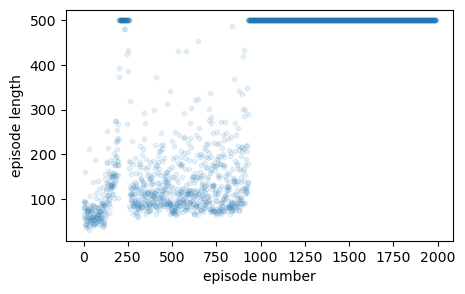

In [5]:
fig,ax=plt.subplots(figsize=(5,3))
ax.scatter(range(len(pgm.episode_rewards)),pgm.episode_rewards,s=10,alpha=0.1)
ax.set_xlabel("episode number")
ax.set_ylabel("episode length")

By the way, I did not manage to completely stabilise the algorithm. If you don't see large episode lengths here, run the training again. Ideally, you should see here a somewhat raggedy trend towards larger epiode lengths.

We also plot the evolution of the weights. 

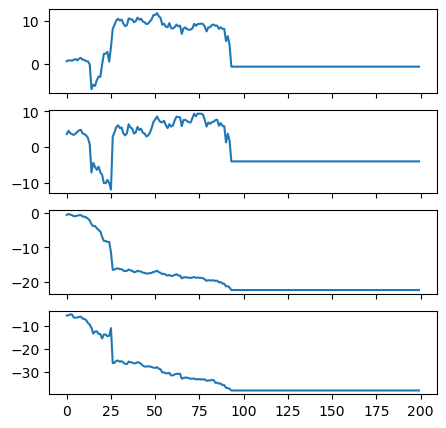

In [6]:
def plot_weight_record(weight_record):
    fig,axs=plt.subplots(4,1,figsize=(5,5),sharex=True)
    
    for ax,weights in zip(axs,np.array(weight_record).T):
        ax.plot(weights)

plot_weight_record(pgm.record)

Let's check the performance of the trained policy. You should see here average episode lengths very close to 500. Even setting <code>max_episode_length</code> to higher values won't change that as the cart pole task comes truncated at 500 time steps.

In [7]:
def stochastic_policy_sampler(policy,weight):
    def sampler(state):
        return sample_action(policy(state,weight))
    return sampler

def play_single_episode(policy,env,max_episode_length=300):
    total_reward=0
    env=TimeLimit(env,max_episode_length)
    state,info=env.reset()
    terminated=False
    truncated=False
    while not terminated and not truncated:
        action=policy(state)
        state,reward,terminated,truncated,info=env.step(action)
        total_reward+=reward
    return total_reward

def play_many_episodes(policy,env,repeats,max_episode_length=300):
    total_rewards=[]
    for i in range(repeats):
        total_rewards.append(play_single_episode(policy,env,max_episode_length=max_episode_length))
    return sum(total_rewards)/len(total_rewards)

policy=stochastic_policy_sampler(linear_policy,pgm.weight)
# note: https://gymnasium.farama.org/environments/classic_control/cart_pole/
# env already truncated to 500 steps
play_many_episodes(policy,env,1000,max_episode_length=500)

500.0

Finally let's inspect a single episode. 

Text(1.01, 0.5, 'action')

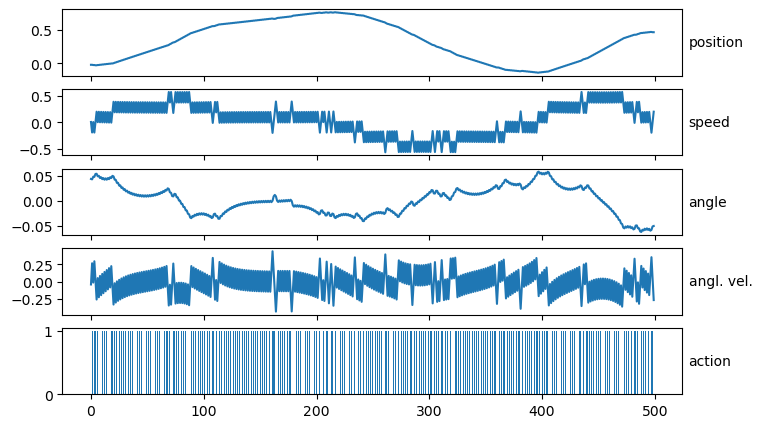

In [8]:
policy=stochastic_policy_sampler(linear_policy,pgm.weight)
total_reward=0
state,info=env.reset()
states=[]
actions=[]
terminated=False
truncated=False
while not terminated and not truncated:
    action=policy(state)
    states.append(state)
    actions.append(action)
    state,reward,terminated,truncated,info=env.step(action)
    total_reward+=reward

## plotting
fig,axs=plt.subplots(5,1,figsize=(8,5),sharex=True)
titles=["position","speed","angle","angl. vel."]
for ax,state_entries,title in zip(axs,np.array(states).T,titles):
    ax.plot(state_entries)
    ax.text(1.01, 0.5, title, rotation=0, ha='left', va='center',transform=ax.transAxes)

axs[-1].bar(range(len(actions)),actions)
axs[-1].text(1.01, 0.5, "action", rotation=0, ha='left', va='center',transform=axs[-1].transAxes)